# Solar evolution models with a central black hole

### Accretion luminosity


[Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_ \
$^3$_Yale University, New Haven, CT_

In [1]:
import os

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import integrate
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from astropy import constants as cnt
from astropy import units as unt

import dask.dataframe as dd
import dask.array as da

from uncertainties import ufloat, unumpy

from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from ipywidgets import interact, FloatSlider, IntSlider

In [2]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('figs/thinfig')
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [3]:
# labels 
density     = r'density $\mathbf{\rho~/~[g/cm^3]}$'
frac_radius = r'fractional radius $\mathbf{r/R_\odot}$'
frac_mass   = r'fractional mass $\mathbf{m/M_\odot}$'
Teff        = r'effective temperature $\mathbf{T_{eff}/K}$'
luminosity  = r'luminosity $\mathbf{L/L_\odot}$'

In [4]:
#dirs = os.listdir('sep_pbh_grid/grid')
dirs = os.listdir('sep_pbh_grid/grid')
dirs = [d for d in dirs if d.startswith('M=')]

print(dirs)

data = {}
for d in dirs:
    M, MBHf = d.split('_')
    M = float(M[2:])
    MBHf = float(MBHf[5:])
    file_path = os.path.join('sep_pbh_grid', 'grid', d, 'LOGS', 'history.data')
    #file_path = os.path.join('pbh_grid', d, 'history.data')
    #print(file)
    if not os.path.exists(file_path):
        continue
    df = pd.read_table(file_path, sep='\s+', skiprows=5)
    data[(M, MBHf)] = df[['star_age', 'log_L', 'log_Teff', 'center_h1', 'M_BH', 'log_LH', 'L_BH']]

data

['M=1_MBHf=-12', 'M=1_MBHf=-11', 'M=1_MBHf=-10', 'M=1_MBHf=-4']


{(1.0,
  -12.0):           star_age     log_L  log_Teff  center_h1          M_BH    log_LH  \
 0     1.000000e-05  0.144994  3.644801   0.722545  1.000000e-12 -4.684460   
 1     2.200000e-05  0.144995  3.644801   0.722545  1.000000e-12 -4.684429   
 2     3.640000e-05  0.144994  3.644801   0.722545  1.000000e-12 -4.684392   
 3     5.368000e-05  0.144994  3.644801   0.722545  1.000000e-12 -4.684348   
 4     7.441600e-05  0.144993  3.644801   0.722545  1.000000e-12 -4.684294   
 ...            ...       ...       ...        ...           ...       ...   
 2043  1.293811e+10  0.336843  3.682091   0.566556  8.872875e-04 -5.378050   
 2044  1.295398e+10  0.343422  3.682076   0.566556  9.099932e-04 -5.409983   
 2045  1.297303e+10  0.347882  3.682065   0.566556  9.375044e-04 -5.431703   
 2046  1.299588e+10  0.356051  3.682040   0.566556  9.711575e-04 -5.471612   
 2047  1.300000e+10  0.361596  3.682021   0.566556  1.012187e-03 -5.498808   
 
               L_BH  
 0     5.021867e-13  
 1

-6.177168777305171


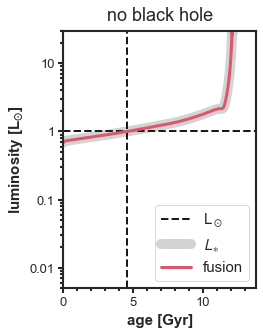

In [5]:
sun = pd.read_table('normal/LOGS/history.data', sep='\s+', skiprows=5)
#sun = pd.read_table('sep_pbh_grid/normal/LOGS/history.data', sep='\s+', skiprows=5)

plt.figure(figsize=(4, 5))

norm = mpl.colors.LogNorm(vmin=10**-20, vmax=1)
cmap = plt.get_cmap('Reds')

plt.axhline(10**0, ls='--', c='k', label=r'L$_\odot$')
plt.axvline(4.572, ls='--', c='k')

plt.plot(sun['star_age']/1e9, 10**sun['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
plt.plot(sun['star_age']/1e9, 10**sun['log_LH'], lw=3, c="#dc576c", label='fusion')

print((sun['star_age'][(10**sun['log_L']<=1).argmin()])/1e9 - (sun['star_age'][(10**sun['log_L']<=2).argmin()])/1e9)

plt.semilogy()
#plt.ylim([1e-2, 1.2e2])
plt.ylim([0.5e-2, 30])
plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])

plt.xlim([0, 13.8])#12.5])

plt.legend()

plt.title(r'no black hole')
#plt.legend()
plt.xlabel('age [Gyr]')
plt.ylabel(r'luminosity [L$_{\mathbf{\odot}}$]')
#plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label=r'black hole mass [M$_{\mathbf{\odot}}$]')
#plt.semilogy()
plt.tight_layout()
plt.savefig('figs/age-lum-0.pdf')
plt.show()

6.566454703185441
5.70362171810285
6.566454703185441
-0.8628329850825911
-0.8357938603312132
1.6508670218623889e-06
-6.0
-5.0
-4.0
-3.0
-2.0


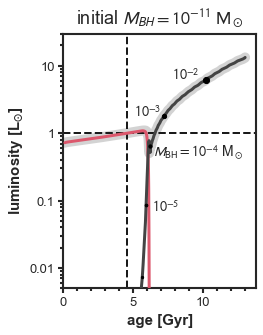

In [6]:
plt.figure(figsize=(4, 5))

norm = mpl.colors.LogNorm(vmin=10**-20, vmax=1)
cmap = plt.get_cmap('Reds')

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-11:
        df = df[df['center_h1'] < df['center_h1'].values[0]*0.995].reset_index()
        
        plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
        plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_BH'], lw=3, c='#444444', label='accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()] - df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9 - (df['star_age'][(df['L_BH']<=2).argmin()])/1e9)
        print(df['M_BH'][np.argmin(df['L_BH']<0.01)])
        
        LBH_func = interp1d(df['star_age']/1e9, df['L_BH'])
        MBH_func = interp1d(df['M_BH'], df['star_age']/1e9)
        masses = np.linspace(-6, -2, num=5)
        for mass in masses:
            print(mass)
            MBH_at_age = MBH_func(10**mass)
            L_BH_at_age = LBH_func(MBH_at_age)
            plt.plot(MBH_at_age, L_BH_at_age, 'o', c='#000000', zorder=99, ms=(15/-mass)**0.9)
            if mass != -4 and mass != -6 and mass != -1 and mass != -5:
                plt.text(0.98*MBH_at_age - (0.3 if mass == -2 else -0.1 if mass == -5 else 0), 
                         L_BH_at_age, r"$10^{"+str(int(mass))+"}$", ha='right', size=14,
                    zorder=9999999)
            elif mass == -4: 
                plt.text(MBH_at_age + 0.25, L_BH_at_age*0.7, 
                         r"$M_{\rm{BH}} = 10^{"+str(int(mass))+"}$ M$_\odot$", ha='left', size=14,
                    zorder=9999999)
            elif mass == -5:
                plt.text(MBH_at_age + 0.4, L_BH_at_age*0.8, 
                         r"$10^{"+str(int(mass))+"}$", ha='left', size=14,
                    zorder=9999999)

plt.axhline(10**0, ls='--', c='k')
plt.axvline(4.572, ls='--', c='k')

plt.semilogy()
plt.ylim([0.5e-2, 30])
plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])

plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$')
plt.xlim([0, 13.8])#12.5])
plt.xlabel('age [Gyr]')
plt.ylabel(r'luminosity [L$_{\mathbf{\odot}}$]')


plt.tight_layout()
plt.savefig('figs/age-lum-11.pdf')
plt.show()

7.203156603135554e-05
1.146526849190823e-06
1.8471671056260524
2.9697058340209694
-1.122538728394917
-0.9347510771882424


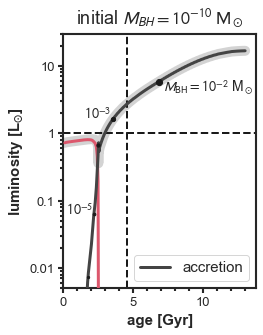

In [7]:
plt.figure(figsize=(4, 5))

norm = mpl.colors.LogNorm(vmin=10**-20, vmax=1)
cmap = plt.get_cmap('Reds')

plt.axhline(10**0, ls='--', c='k')#, label=r'L$_\odot$')
plt.axvline(4.572, ls='--', c='k')

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-10:
        #df = df[df.star_age < df.star_age.values[-1]*.99]
        df = df[df['center_h1'] < df['center_h1'].values[0]*0.995].reset_index()
        
        plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99)
        plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_BH'], lw=3, c='#444444', label='accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        print(df['M_BH'][np.argmin(df['L_BH']<10**df['log_LH'])])
        print(df['M_BH'][np.argmin(df['L_BH']<0.01*10**df['log_LH'])])
        #print(df['M_BH'])
        #plt.scatter(10**df['log_Teff'], 10**df['log_L'], c=df['star_age']/1e9, 
        #            alpha=1)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()] - df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9 - (df['star_age'][(df['L_BH']<=2).argmin()])/1e9)
        
        
        
        LBH_func = interp1d(df['star_age']/1e9, df['L_BH'])
        MBH_func = interp1d(df['M_BH'], df['star_age']/1e9)
        masses = np.linspace(-6, -2, num=5)#np.logspace(-6, -1, num=6)
        for mass in masses:
            MBH_at_age = MBH_func(10**mass)
            L_BH_at_age = LBH_func(MBH_at_age)
            plt.plot(MBH_at_age, L_BH_at_age, 'ko', zorder=99, ms=(15/-mass)**0.9)
            if mass != -4 and mass != -2 and mass != -6 and mass != -1:
                plt.text(0.95*MBH_at_age - (0.3 if mass == -2 else -0.1 if mass == -5 else 0), 
                         L_BH_at_age, r"$10^{"+str(int(mass))+"}$", ha='right', size=14,
                    zorder=9999999)
            elif mass == -2: 
                plt.text(MBH_at_age + 0.3, L_BH_at_age*0.7, 
                         r"$M_{\rm{BH}} = 10^{"+str(int(mass))+"}$ M$_\odot$", 
                         ha='left', size=14,
                         zorder=9999999)
                
#plt.semilogy()
plt.xlim([0, 13.5])#12.5])
plt.title(r'initial $M_{BH} = 10^{-10}~\rm{M}_\odot$')


plt.semilogy()
plt.ylim([0.5e-2, 30])
plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])

plt.xlim([0, 13.8])#12.5])

plt.legend()
plt.xlabel('age [Gyr]')
plt.ylabel(r'luminosity [L$_{\mathbf{\odot}}$]')
#plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label=r'black hole mass [M$_{\mathbf{\odot}}$]')
#plt.semilogy()
plt.tight_layout()
plt.savefig('figs/age-lum-10.pdf')
plt.show()

0.45267204415141216


(6.5, 7.5)

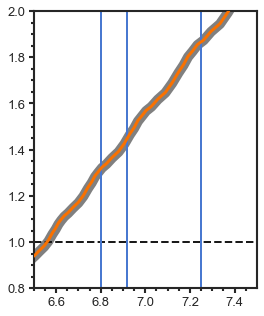

In [8]:
plt.figure(figsize=(4, 5))

norm = mpl.colors.LogNorm(vmin=10**-20, vmax=1)
cmap = plt.get_cmap('Reds')

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-11:
        plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='gray', zorder=-99, label=r'$L_\ast$')
        plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c=red, label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_BH'], lw=3, c=orange, label='accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        
        print(10**df['log_L'].min())

plt.axhline(1, ls='--', c='k')
plt.axvline(6.8)
plt.axvline(6.92)
plt.axvline(7.25)
plt.axhline(0.52)
plt.ylim([0.8, 2e0])
plt.xlim([6.5,7.5])
#plt.semilogy()